In [1]:
import glob
import numpy as np
import scipy as sp
import einops as eo
import matplotlib.pyplot as plt
import math
import plotly.graph_objects as go
from scipy.spatial.transform import Rotation
import magpylib as magpy
import os
import pandas as pd
from datetime import timedelta
import sys
from datetime import datetime
import multiprocessing as mp

M0 = 1480 #mT
shape = [[5*25.4/16, 25.4/8], [5*25.4/16, 2*25.4/8]] #radius and height

x0 = np.array([0,0,10, 0,0,1])

In [2]:
def B_dipole(position, rotation, M0, shape):
    R = np.sqrt(np.sum(position**2, axis=1))
    B = (M0 * (shape[0]) ** 2 * shape[1] / (16)) * (
        (
            3
            * position
            / R[:, np.newaxis] ** 5
            * (eo.einsum(position, rotation, "sensor dim,  dim -> sensor"))[
                :, np.newaxis
            ]
        )
        - rotation[np.newaxis, :] / (R[:, np.newaxis] ** 3)
    )
    return B


def getField_dipole(x, positions, M0, shape):
    position = x[:3]
    axis = x[3:]
    return B_dipole(positions - position, axis, M0, shape)


def getField_dipole_fixed(x, positions, M0, shape):
    position = x[:3]
    axis = x[3:]
    return B_dipole(positions - position, axis, M0, shape)


def cost_dipole(x, B, positions, M0, shape):
    diff = getField_dipole(x, positions, M0, shape) - B
    return np.sum((diff) ** 2)


def getField_cylinder(x, positions, M0, shape):
    B=magpy.getB(
        sources="Cylinder",
        position=x[:3],
        orientation=Rotation.align_vectors(x[3:], np.array([0, 0, 1]))[0],
        observers=positions,
        dimension=shape,
        polarization=(0, 0, M0),
    )
    return B

def cost_cylinder(x, B, positions, M0, shape):
    diff = getField_cylinder(x, positions, M0, shape) - B
    return np.sum((diff) ** 2)

def minimize(x0, B, positions, M0, shape, *args):
    #print("Starting mimimization")
    b_args = (B, positions, M0, shape)
    cons = [{"type": "eq", "fun": lambda x: x[3] ** 2 + x[4] ** 2 + x[5] ** 2 - 1}]
    bounds = [(-100, 100), (-100, 100), (0, 100), (-1, 1), (-1, 1), (-1, 1)]
    res = sp.optimize.minimize(
        fun=cost_dipole, x0=x0, args=b_args, tol=1e-100, constraints=cons, bounds=bounds, options={'maxiter':100000}, *args
    ) 
    #print(f"Finished mimimization with shape {b_args[3]} at {res}")
    return res.x 

def circle_radius(x1, y1, x2, y2, x3, y3):
    # Calculate lengths of sides of the triangle formed by the three points
    a = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    b = math.sqrt((x3 - x2) ** 2 + (y3 - y2) ** 2)
    c = math.sqrt((x3 - x1) ** 2 + (y3 - y1) ** 2)

    # Calculate the semi-perimeter of the triangle
    s = (a + b + c) / 2

    # Calculate the area of the triangle using Heron's formula
    area = math.sqrt(s * (s - a) * (s - b) * (s - c))

    # Calculate the radius of the circle using the formula: radius = (abc) / (4 * area)
    radius = (a * b * c) / (4 * area)
    
    return radius

def comparison_plot(locact, locpred, axis, relative):

    if axis == 'x':
        ax = 0
    elif axis == 'y':
        ax = 1
    else:
        ax = 2

    index = list(range(len(locact[:,ax])))
    act = locact[:, ax]
    pred = locpred[:, ax]

    rel = ''

    if relative==True:
        act = [x - locact[0, ax] for x in locact[:, ax]]
        pred = [x - locpred[0, ax] for x in locpred[:, ax]]
        rel = ' (Relative)'

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.scatter(index, pred, label='Predicted' + rel)
    plt.scatter(index, act, label='Actual' + rel)
    plt.xlabel('Time Passed (s)')
    plt.ylabel(axis + '-component')
    plt.title('Comparison of '+axis+ ' Location' + rel+ ': Predicted vs Actual')
    plt.legend()
    plt.grid(True)
    plt.show()

    return

def comp_plot3D(locact, locpred, xact, yact, axis, relative):

    if axis == 'x':
        ax = 0
    elif axis == 'y':
        ax = 1
    else:
        ax = 2

    index = list(range(len(locact[:,ax])))
    act = locact[:, ax]
    pred = locpred[:, ax]

    rel = ''

    if relative==True:
        act = [x - locact[0, ax] for x in locact[:, ax]]
        pred = [x - locpred[0, ax] for x in locpred[:, ax]]
        rel = ' (Relative)'

    fig = go.Figure(data=[
        go.Scatter3d(x=xact, y=yact, z=pred, name='Predicted' + rel),
        go.Scatter3d(x=xact, y=yact, z=act, name='Actual' + rel)])
    fig.show()

    return

def displacement_plot(actual, predicted):

    dispx = np.array(predicted[:,0]-predicted[:,0][0])
    dispy = np.array(predicted[:,1]-predicted[:,1][0])
    dispz = np.array(predicted[:,2]-predicted[:,2][0])
    disp = np.sqrt(dispx**2+dispy**2+dispz**2)
    actdispx = np.array(actual[:,0]-actual[:,0][0])
    actdispy = np.array(actual[:,1]-actual[:,1][0])
    actdispz = np.array(actual[:,2]-actual[:,2][0])
    actdisp = np.sqrt(actdispx**2+actdispy**2+actdispz**2)

    plt.figure(figsize=(8, 6))
    plt.scatter(list(range(len(disp))), disp, label='Predicted Displacement')
    plt.scatter(list(range(len(actdisp))), actdisp, label='Actual Displacement')
    plt.xlabel('Time Passed (s)')
    plt.ylabel('Displacement (mm)')
    plt.title('Magnet Displacement')
    plt.legend()
    plt.grid(True)
    plt.show()

    return

# Function to convert HHMMSS to seconds
def time_to_seconds(time_str):
    hours = int(time_str[:2])
    minutes = int(time_str[2:4])
    seconds = int(time_str[4:6])
    return hours * 3600 + minutes * 60 + seconds

def time_to_secondsdf(time_value):
    return time_value.hour * 3600 + time_value.minute * 60 + time_value.second + time_value.microsecond / 1e6

# Function to extract the timestamp part from the file path
def extract_timestamp(file_path):
    # Extract the filename from the file path (without the extension)
    filename = os.path.basename(file_path).replace('.npz', '')
    
    # Split the filename into date, time, and millisecond parts
    date_part = filename.split('-')[0]  # Extracting the 'YYYYMMDD' partshapeimpo
    time_part = filename.split('-')[1]  # Extracting the 'HHMMSS' part
    millisecond_part = filename.split('-')[2]  # Extracting the millisecond part
    
    # Combine date, time, and milliseconds into a full timestamp string
    full_datetime_str = f"{date_part} {time_part}.{millisecond_part}"
    
    # Create a datetime object
    full_datetime = datetime.strptime(full_datetime_str, "%Y%m%d %H%M%S.%f")
    
    return full_datetime

def importfitting(folder, shape):

    file_list = sorted(glob.glob(f'{folder}/*.npz'))
    #print(file_list)
    data = np.load(file_list[0])
    pos = data['pos'][0]
    timestamps = []

    locpred = [np.array([0,0,0])]
    anglepred = [np.array([0,0,0])]
    Bstdev = [np.array(pos)]
    for x in range(len(file_list)):
        try:
            data = np.load(file_list[x])
        except:
            display(file_list[x])
        mags = data['mags']
        pos = data['pos'][0]
        B = np.mean(mags, axis=0)
        mags_stdev = np.std(mags, axis=0)
        timestamps.append(extract_timestamp(file_list[x]))

        x_res = minimize(x0, B, pos, M0, shape)
        locpred = np.append(locpred, [x_res[0:3]], axis=0)
        anglepred = np.append(anglepred, [x_res[3:6]], axis=0)
        Bstdev = np.append(Bstdev, [mags_stdev], axis=0)
    locpred = np.delete(locpred, 0, axis=0)
    anglepred = np.delete(anglepred, 0, axis=0)
    Bstdev = np.delete(Bstdev, 0 ,axis=0)

    return pos, mags, locpred, anglepred, Bstdev, timestamps

def importdata(folder):

    file_list = sorted(glob.glob(f'{folder}/*.npz'))
    #print(file_list)
    data = np.load(file_list[0])
    pos = data['pos'][0]
    B = [np.array(pos)]
    timestamps = []

    for x in range(len(file_list)):
        try:
            data = np.load(file_list[x])
        except:
            display(file_list[x])
        mags = data['mags']
        pos = data['pos'][0]
        mags = np.mean(mags, axis=0)
        
        B = np.append(B, [mags], axis=0)
        timestamps.append(extract_timestamp(file_list[x]))  
    B = np.delete(B, 0, axis=0)

    return B, timestamps

def actualangle(xind, yind, xscal, xcon, yscal, ycon, isoff):

    angact = [np.array([0, 0, 0])]
    for y in range(yind):
        for x in range(xind):
            R = Rotation.from_euler('ZYX' ,np.array([0, yscal*y-ycon, xscal*x-xcon]), degrees=True)
            norm = np.array([[0, 0, 1]])
            rotated = R.apply(norm, inverse=False)[0]
            #add = np.array([np.sin(np.deg2rad(2*y-4)), -np.sin(np.deg2rad(2*x-4)), np.cos(np.deg2rad(2*y-4))*np.cos(np.deg2rad(2*x-4))])
            angact = np.append(angact, [rotated], axis=0)
    angact = np.delete(angact, 0, axis=0)
    locact = angact*isoff

    return angact, locact

def sensorplots(B, timestamps,sensor):
    mag = [np.array([0, 0, 0])]
    for x in range(len(B)):
        mag = np.append(mag, [B[x][sensor]], axis=0)
    mag = np.delete(mag, 0, axis=0)

    measuredbx = go.Scatter(x=timestamps, y=mag[:,0], mode='markers')
    layoutbx = go.Layout(title='b_x over time, sensor ' + str(sensor))
    figbx = go.Figure(data=[measuredbx], layout=layoutbx)
    figbx.update_yaxes(scaleanchor='y')
    figbx.update_layout(
        xaxis_title="Time",
        yaxis_title="b_x [mT]"
    )
    figbx.show()

    measuredby = go.Scatter(x=timestamps, y=mag[:,1], mode='markers')
    layoutby = go.Layout(title='b_y over time sensor ' + str(sensor))
    figby = go.Figure(data=[measuredby], layout=layoutby)
    figby.update_yaxes(scaleanchor='y')
    figby.update_layout(
        xaxis_title="Time",
        yaxis_title="b_y [mT]"
    )
    figby.show()

    measuredbz = go.Scatter(x=timestamps, y=mag[:,2], mode='markers')
    layoutbz = go.Layout(title='b_z over time sensor ' + str(sensor))
    figbz = go.Figure(data=[measuredbz], layout=layoutbz)
    figbz.update_yaxes(scaleanchor='y')
    figbz.update_layout(
        xaxis_title="Time",
        yaxis_title="b_z [mT]"
    )
    figbz.show()

In [3]:
folder = os.path.join('..', './MLX04152025_Server1-1')
B, timestamps = importdata(folder)

In [4]:
sensorplots(B, timestamps, 6)

import functions from MagneticSensorTracking
graph bx, by, bz for all 16 sensors
try averaging the sensors logs
try restarting pi to see if time error is from restarts
fix the mount

In [5]:
pos, mags, locpred, anglepred, Bstdev, timestamps = importfitting(folder, shape[0])
np.append(locpred, anglepred, axis=1)
#print(timeelapsed)
print(len(locpred))

rel_loc_predx = [x - locpred[0,0] for x in locpred[:,0]]
rel_loc_predy = [x - locpred[0,1] for x in locpred[:,1]]
rel_loc_predz = [x - locpred[0,2] for x in locpred[:,2]]


dispx = np.array(rel_loc_predx)
dispy = np.array(rel_loc_predy)
dispz = np.array(rel_loc_predz)
disp = np.sqrt(dispx**2+dispy**2+dispz**2)

c:\Users\Brandon Nguyen\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_slsqp_py.py:434: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds



1160


In [6]:
folder2 = os.path.join('..', './MLX04152025_Server2-1')
B2, timestamps2 = importdata(folder2)

In [7]:
sensorplots(B2, timestamps2, 6)

In [8]:
pos2, mags2, locpred2, anglepred2, Bstdev2, timestamps2 = importfitting(folder2, shape[1])
np.append(locpred2, anglepred2, axis=1)
#print(timeelapsed)
print(len(locpred2))

rel_loc_predx2 = [x - locpred2[0,0] for x in locpred2[:,0]]
rel_loc_predy2 = [x - locpred2[0,1] for x in locpred2[:,1]]
rel_loc_predz2 = [x - locpred2[0,2] for x in locpred2[:,2]]



dispx2 = np.array(rel_loc_predx2)
dispy2 = np.array(rel_loc_predy2)
dispz2 = np.array(rel_loc_predz2)
disp2 = np.sqrt(dispx2**2+dispy2**2+dispz2**2)

464


In [9]:
folder3 = os.path.join('..', './MLX04152025_Server3-1')
B3, timestamps3 = importdata(folder3)

In [10]:
sensorplots(B3, timestamps3, 6)

In [11]:
pos3, mags3, locpred3, anglepred3, Bstdev3, timestamps3 = importfitting(folder3, shape[0])
np.append(locpred3, anglepred3, axis=1)
#print(timeelapsed)
print(len(locpred3))

rel_loc_predx3 = [x - locpred3[0,0] for x in locpred3[:,0]]
rel_loc_predy3 = [x - locpred3[0,1] for x in locpred3[:,1]]
rel_loc_predz3 = [x - locpred3[0,2] for x in locpred3[:,2]]



dispx3 = np.array(rel_loc_predx3)
dispy3 = np.array(rel_loc_predy3)
dispz3 = np.array(rel_loc_predz3)
disp3 = np.sqrt(dispx3**2+dispy3**2+dispz3**2)

361


In [12]:
# Specify the Excel file name (replace with your actual file name)
file = '04152025_HDMM.txt'

# Create the full file path
file_path = os.path.join('..', file)

# Read the Excel file into a pandas DataFrame
df = pd.read_csv(file_path, delimiter=',', na_values="        NaN")

df.dropna(inplace=True)
df[['X', 'Y', 'Z', 'Displacement [mm]']] = df[['X', 'Y', 'Z', 'Displacement [mm]']].apply(pd.to_numeric,errors='coerce')
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%dT%H:%M:%S.%f')
df['datetime'] = df.loc[0:,'Time'].dt.time


print(df)
hdmm_time = df['Time']
hdmm_disp = df.loc[0:,'Displacement [mm]']
hdmm_x = df.loc[0:, 'X']
hdmm_y = df.loc[0:, 'Y']
hdmm_z = df.loc[0:, 'Z']
print(hdmm_time)

                       Time     X     Y     Z  Displacement [mm]  \
4   2025-04-15 17:06:28.748  0.00  0.00  0.00               0.00   
5   2025-04-15 17:06:29.249 -0.01 -0.01 -0.01               0.01   
6   2025-04-15 17:06:29.764  0.00 -0.01 -0.03               0.03   
7   2025-04-15 17:06:30.280 -0.01  0.01 -0.02               0.03   
8   2025-04-15 17:06:30.779 -0.00  0.01  0.02               0.02   
..                      ...   ...   ...   ...                ...   
442 2025-04-15 17:10:17.968  0.11  0.00 -0.09               0.14   
443 2025-04-15 17:10:18.486  0.10  0.01 -0.07               0.12   
444 2025-04-15 17:10:19.002  0.10 -0.02 -0.09               0.14   
445 2025-04-15 17:10:19.517  0.10 -0.01 -0.13               0.16   
446 2025-04-15 17:10:20.016  0.11 -0.00 -0.09               0.14   

            datetime  
4    17:06:28.748000  
5    17:06:29.249000  
6    17:06:29.764000  
7    17:06:30.280000  
8    17:06:30.779000  
..               ...  
442  17:10:17.968000  

In [31]:
def align_timestamps(data1, timestamps1, data2, timestamps2):
    """
    Aligns the timestamps of the second dataset to the first dataset based on the maximum values.
    
    Args:
    - data1 (list or array-like): First dataset.
    - timestamps1 (list or array-like): Timestamps associated with the first dataset.
    - data2 (list or array-like): Second dataset.
    - timestamps2 (list or array-like): Timestamps associated with the second dataset.

    Returns:
    - pd.Series: Adjusted timestamps for the second dataset.
    """
    # Convert inputs to numpy arrays and pandas datetime for handling
    data1 = np.array(data1)
    data2 = np.array(data2)
    timestamps1 = pd.to_datetime(timestamps1)
    timestamps2 = pd.to_datetime(timestamps2)
    
    # Find the indices of the maximum values
    max_index1 = np.argmax(data1)
    max_index2 = np.argmax(data2)
    
    # Find the time difference between the max values
    time_diff = timestamps1[max_index1] - timestamps2[max_index2]
    print(time_diff)
    # Adjust the timestamps of the second dataset
    adjusted_timestamps = timestamps2 + time_diff
    
    return time_diff, adjusted_timestamps

tdiff, hdmm_timecorr = align_timestamps(disp3, timestamps3, hdmm_disp, hdmm_time)
display(hdmm_timecorr)
display(tdiff)

-1 days +23:59:28.817660


4     2025-04-15 17:05:57.565660
5     2025-04-15 17:05:58.066660
6     2025-04-15 17:05:58.581660
7     2025-04-15 17:05:59.097660
8     2025-04-15 17:05:59.596660
                 ...            
442   2025-04-15 17:09:46.785660
443   2025-04-15 17:09:47.303660
444   2025-04-15 17:09:47.819660
445   2025-04-15 17:09:48.334660
446   2025-04-15 17:09:48.833660
Name: Time, Length: 443, dtype: datetime64[ns]

Timedelta('-1 days +23:59:28.817660')

In [14]:
print(timestamps[0])
print(timestamps[-1])
print('-----------------------')
print(timestamps2[0])
print(timestamps2[-1])
print('-----------------------')
print(timestamps3[0])
print(timestamps3[-1])
print('-----------------------')

2025-04-15 16:57:45.828604
2025-04-15 17:09:07.687856
-----------------------
2025-04-15 17:03:49.378684
2025-04-15 17:09:05.805043
-----------------------
2025-04-15 17:05:04.891508
2025-04-15 17:09:03.585333
-----------------------


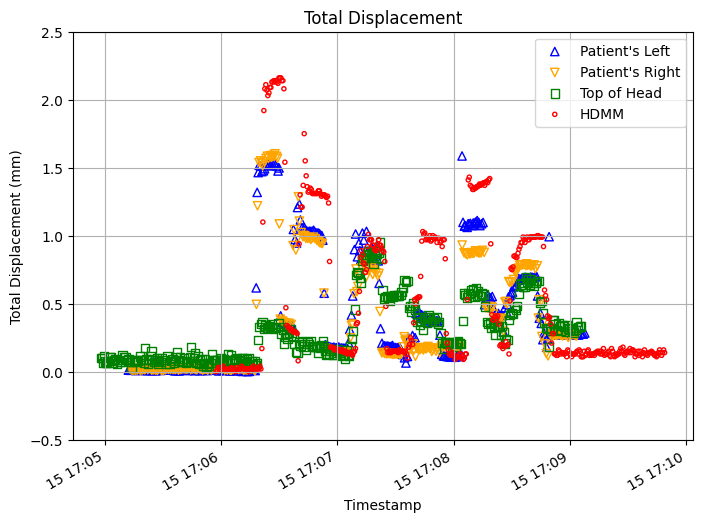

In [34]:
# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(timestamps[-350:], disp[-350:], label="Patient's Left", marker='^', edgecolors='blue', facecolors='none')
plt.scatter(timestamps3[-350:], disp3[-350:], label="Patient's Right", marker='v', edgecolors='orange', facecolors='none')
plt.scatter(timestamps2[-350:], disp2[-350:], label='Top of Head', marker='s', edgecolors='green', facecolors='none')
plt.scatter(hdmm_timecorr[-500:], hdmm_disp[-500:], label='HDMM', marker='.', color='red', facecolors='none')
#plt.scatter(hdmm_time[a:b], hdmm_disp2)
# Set x-axis labels to show only the time
# Format the x-axis to show date and time properly
plt.gcf().autofmt_xdate()  # Auto-format the dates on the x-axis
plt.xlabel('Timestamp')
plt.ylabel('Total Displacement (mm)')
plt.ylim(-0.5, 2.5)
plt.title('Total Displacement')
plt.legend()
plt.grid(True)
plt.show()

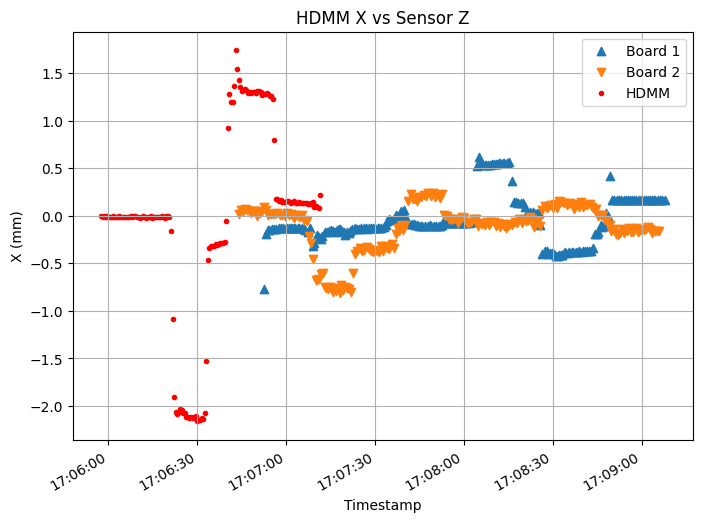

In [16]:
# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(timestamps[-200:], rel_loc_predz[-200:], label='Board 1', marker='^')
plt.scatter(timestamps2[-200:], rel_loc_predz2[-200:], label='Board 2', marker='v')
plt.scatter(hdmm_timecorr[-900:-300], hdmm_x[-900:-300], label='HDMM', marker='.', color='red')
plt.gcf().autofmt_xdate()  # Auto-format the dates on the x-axis
plt.xlabel('Timestamp')
plt.ylabel('X (mm)')
#plt.ylim(-0.5, 2.5)
plt.title('HDMM X vs Sensor Z')
plt.grid(True)
plt.legend()
plt.show()

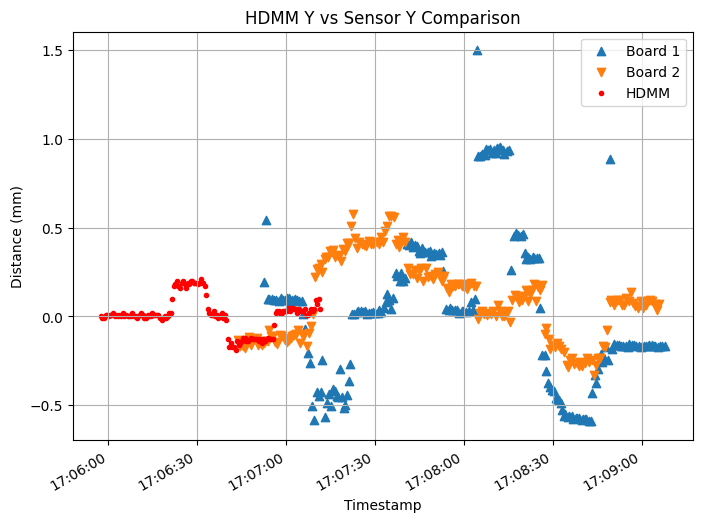

In [17]:
# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(timestamps[-200:], -np.array(rel_loc_predy[-200:]), label='Board 1', marker='^')
plt.scatter(timestamps2[-200:], -np.array(rel_loc_predy2[-200:]), label='Board 2', marker='v')
plt.scatter(hdmm_timecorr[-900:-300], hdmm_y[-900:-300], label='HDMM', marker='.', color='red')
plt.gcf().autofmt_xdate()  # Auto-format the dates on the x-axis
plt.xlabel('Timestamp')
plt.ylabel('Distance (mm)')
#plt.ylim(-0.5, 2.5)
plt.title('HDMM Y vs Sensor Y Comparison')
plt.grid(True)
plt.legend()
plt.show()

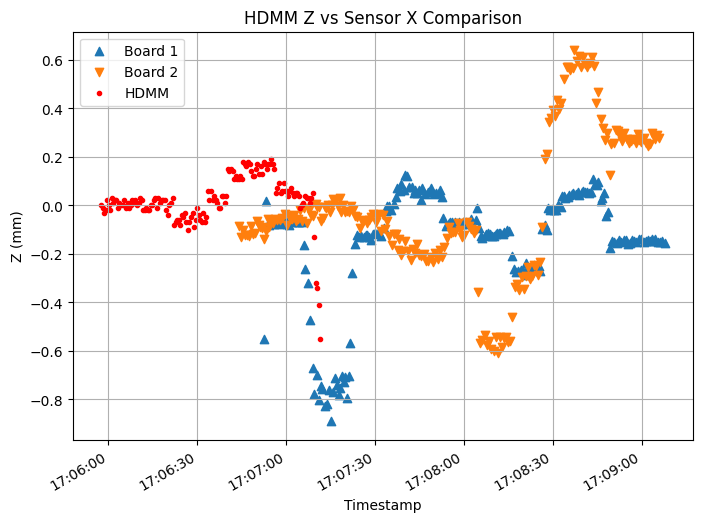

In [18]:
# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(timestamps[-200:], rel_loc_predx[-200:], label='Board 1', marker='^')
plt.scatter(timestamps2[-200:], rel_loc_predx2[-200:], label='Board 2', marker='v')
plt.scatter(hdmm_timecorr[-900:-300], hdmm_z[-900:-300], label='HDMM', marker='.', color='red')
plt.gcf().autofmt_xdate()  # Auto-format the dates on the x-axis
plt.xlabel('Timestamp')
plt.ylabel('Z (mm)')
plt.title('HDMM Z vs Sensor X Comparison')
plt.grid(True)
plt.legend()
plt.show()

Try multiprocessing? simultaneous multi sensor data?
Finish 3d printing new top head mount, prototype side head mount
Fix time correction function


4/16/2025
Fix multiprocessing, make a mlx fitting package

fix top head mount + top magnet position

followup on CMRR reflow + pcb manufacturing

qwiic cables/hardware at microcenter